# **Import Statements**

In [48]:
import opensim as osim
import matplotlib.pyplot as plt
import numpy as np
osim.GetVersionAndDate()

'version 4.5.2-2025-04-07-2c9fc5bc9, build date 09:56:22 Apr  9 2025'

# **Model Loading**

In [ ]:
# Load the model.
arm26 = osim.Model('OpenSIM_utils\\Arm26\\arm26.osim')

# Print metadata.
print("Name of the model:", arm26.getName())
print("Author:", arm26.get_credits())
print("Publications:", arm26.get_publications())
print("Length Unit:", arm26.get_length_units())
print("Force Unit:", arm26.get_force_units())
print("Gravity:", arm26.get_gravity())

# Use the TableProcessor to read the motion file.
tableTime = osim.TimeSeriesTable('OpenSIM_utils\\Arm26\\OutputReference\\InverseKinematics\\arm26_InverseKinematics.mot')
print(tableTime.getColumnLabels())

#Named variables
r_shoulder_elev = tableTime.getDependentColumn('r_shoulder_elev').to_numpy()
r_elbow_flex = tableTime.getDependentColumn('r_elbow_flex').to_numpy()
t = tableTime.getIndependentColumn()


Name of the model: arm26
Author: The OpenSim Development Team (Reinbolt, J; Seth, A; Habib, A; Hamner, S) adapted from a model originally created by Kate Holzbaur (11/22/04) License: Creative Commons (CCBY 3.0). You are free to distribute, remix, tweak, and build upon this work, even commercially, as long as you credit us for the original creation. http://creativecommons.org/licenses/by/3.0/
Publications: Holzbaur, K.R.S., Murray, W.M., Delp, S.L. A Model of the Upper Extremity for Simulating Musculoskeletal Surgery and Analyzing Neuromuscular Control. Annals of Biomedical Engineering, vol 33, pp 829–840, 2005
Length Unit: meters
Force Unit: N
Gravity: ~[0,-9.8066,0]
('r_shoulder_elev', 'r_elbow_flex')


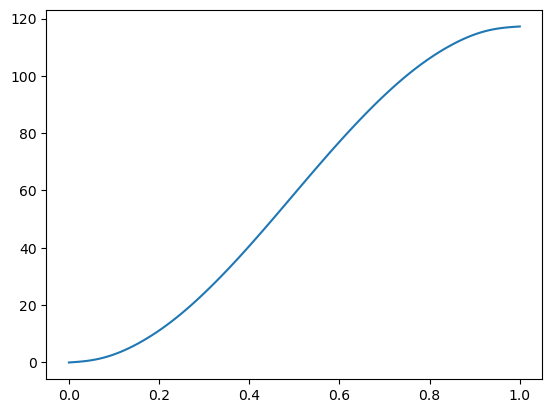

In [5]:
plt.plot(t, r_elbow_flex*1.3)
plt.show()


In [52]:
class Bicep_Curl: 

    def __init__(self, curl_time = 2, rom = 135, sps = 250, base_path = 'OpenSIM_utils\\Arm26\\Flexiforce\\', model = 'arm26.osim'):
        '''
        curl_time: duration of the biceps curl in seconds
        rom: range of motion of the elbow joint; ie: following a trajectory from 0 degrees to rom degrees
        sps: steps per second, defines the resolution of the simulation

        base_path: path to the directory with the .osim model and where static optimization results will be stored
        model: .osim filename of the model in the base_path directory to be used for the analysis
        '''
        
        #Housekeeping
        self.base_path = base_path
        self.traj_path = base_path + 'bicep_curl.sto'
        self.force_path = base_path + 'robot_force.sto'
        self.model = osim.Model(base_path + model)
        self.model.setup()
        self.state = self.model.initSystem()

        #Generate Elbow Trajectory from desired characteristics
        self.t = np.linspace(0, curl_time, int(curl_time*sps))
        k = 12/curl_time
        b = curl_time/2
        self.elbow_trajectory = rom/(1 + np.exp(-k*(self.t-b)))

        #Initialize trajectory and forces dictionaries
        self.traj_dict = {
            "r_shoulder_elev": np.zeros(self.t.shape),
            "r_elbow_flex": self.elbow_trajectory
        }
        self.force_dict = {
            "Fz": np.zeros(self.t.shape)
        }
        
        #Create Tables
        self.traj_table = self.make_OSIMtable(self.traj_dict)
        self.force_table = self.make_OSIMtable(self.force_dict)

        #Convert Table objects to .sto
        self.sto = osim.STOFileAdapter()
        self.sto.write(self.traj_table, self.traj_path)
        self.sto.write(self.force_table, self.force_path)

        #Initialize Static Optimizer/Tools
        self.optimizer = osim.StaticOptimization()
        self.analyzer = osim.AnalyzeTool()
        self.analyzer.setModel(self.model)
        self.analyzer.setModelFilename(self.model.getDocumentFileName())
        self.analyzer.setCoordinatesFileName(self.traj_path)
        self.analyzer.setExternalLoadsFileName(self.force_path)
        self.analyzer.setStatesFromMotion(self.state, osim.Storage(self.traj_path), True)
        self.analyzer.setName("Bicep_Curl")

        

    def step_simulation(self, step_index, force_vector):
        
        #Set time of step in Static Optimizer/Tools
        t = self.t[step_index]
        self.optimizer.setStartTime(t)
        self.optimizer.setEndTime(t)
        self.analyzer.setStartTime(t)
        self.analyzer.setFinalTime(t)

        #add force_vector to time index
        robot_force = osim.TimeSeriesTable(self.force_path)
        Fz = robot_force.getDependentColumn('Fz').to_numpy()
        Fz[step_index] = force_vector
        force_dict = {
            "Fz": Fz
        }
        self.force_table = self.make_OSIMtable(force_dict)
        self.sto.write(self.force_table, self.force_path)

        #Setup step analyzer
        self.step_analysis = self.analyzer.clone()
        self.step_analysis.updAnalysisSet().cloneAndAppend(self.optimizer)

        #Run
        self.step_analysis.setResultsDir(self.base_path + "\\Results")
        self.step_analysis.run()

        #Access Results to return biceps activation
        results = osim.TimeSeriesTable()

        return 



    def make_OSIMtable(self, columns = dict):
        OSIMtable = osim.TimeSeriesTable(self.t)
        for key, value in columns.items():
            OSIMtable.appendColumn(key, osim.Vector.createFromMat(value))

        return OSIMtable
    


    def _reset(self):
        for key, _ in self.force_dict.item():
            self.force_dict[key] = np.zeros(self.t.shape)
        self.force_table = self.make_OSIMtable(self.force_dict)
        self.sto.write(self.force_table, self.force_path)



curl_exercise = Bicep_Curl()
curl_exercise.step_simulation(0, 0.0)

RuntimeError: std::exception in 'bool OpenSim::AnalyzeTool::run()': Object: Could not open file IO. It may not exist or you don't have permission to read it.